# Learning CartPole with Q-Learning!
This notebook will tackle the game of CartPole using a value-based reinforcement learning method known as Q-Learning! The CartPole environment is readily available through OpenAI's gym module.

## Q-Learning
The idea of value-based reinforcement learning methods are to indirectly find the optimal-policy of a task by first estimating the worth of a particular state under some policy governed by these values. More succinctly, the expected future returns of each state are calculated and a policy is found by (usually) acting greedily with respect to these values.

Assuming that our system is a Markov Decision Process (MDP), the expected reward for being in a particular state s and following some fixed policy $\pi$ in terms of the expected reward of the next state can be expressed by the state-value Bellman Equation:

$$V^{\pi}(s) = \sum_{a} \pi (s, a) \sum_{s'} \mathcal{P}_{s s'}^{a} \Big[ \mathcal{R}_{s s'}^{a} + \gamma V^{\pi}(s') \Big] $$

$$Q^{\pi}(s,a) = \sum_{s'} \mathcal{P}_{s s'}^{a} \Big[ \mathcal{R}_{s s'}^{a} + \gamma \sum_{a'} \pi (s', a') Q^{\pi}(s', a') \Big]$$

Similarly, the expected reward for being in a particular state s, taking an action a, and then following a fixed policy $\pi$ can be expressed by the action-value Bellman Equation:

where $\mathcal{R}_{s s'}^{a}$ is the reward function, $\gamma$ is the discount factor, $\mathcal{P}_{s s'}^{a}$ are the transition probabilties, and $V^{\pi}(*)$ is the state-value function under a policy, $\pi$.


By choosing the action that gives rise to the highest expected return (acting greedily), we can then write the Bellman Equations that mimics this behaviour, known as the Bellman Optimality Equations.

$$V^{*}(s) = \max_a\sum_{s'} \mathcal{P}_{s s'}^{a} \Big[ \mathcal{R}_{s s'}^{a} + \gamma V^{*}(s') \Big] $$
$$Q^{*}(s,a) = \sum_{s'} \mathcal{P}_{s s'}^{a} \Big[ \mathcal{R}_{s s'}^{a} + \gamma \max_{a'} Q^{*}(s', a') \Big]$$

Generally, if the MDP is fully-defined it is possible to solve for these state-values for all states using dynamic programming. Unfortunately, in most cases, the MDP is not completely known and therefore other methods are needed to solve the Bellman Equations. 

One such method of solving the Bellman Optimality Equation is Q-learning. It is an off-policy TD-learning method that uses gradient descent updates at every step when the agent is exploring the environment. 

$$Q_{t+1}^\pi(s_n, a_n) = Q_t^\pi(s_n, a_n) + \alpha \bigg[\mathcal{R}_{s s'}^{a} + \gamma \max_{a'} Q_t^\pi(s_{n+1}, a') - Q_t^\pi(s_n, a_n)\bigg]$$

When dealing with a discrete state-space, action-values can be stored in a table -- but when dealing with continous state-spaces, this becomes intractable. As a result, the action-value function has to be approximated. Neural networks are great function-approximators, and such they are a good tool to use for this task.

### Experience Replay
In the vanilla Q-learning algorithm, when the agent is roaming around the environment, gradient descent updates occur at every step for each sample of experience it receives. The experience is then 'thrown away' and not used again. As you can imagine, this is an extremely wasteful use of data. As such, a method known as 'Experience Replay' was devised, where experience (S, A, R, S) is stored into a buffer and at every step N samples of previous experience are randomly sampled from this buffer to make a gradient descent update. This is much more data efficient and generally allows the action-values to converge faster. 

Additionally, using consecutive samples to update the weights is inefficient, due to the strong correlations
between the samples. Experience replay helps alleviate this correlation by randomly sampling the experience, thus allowing for more efficient gradient updates by reducing the variance in the samples. 

### Target Network
Since the action-value function is constantly changing at every step, the target values derived from them are also constantly changing! That means we are trying to learn a mapping between inputs and outputs, where the outputs are constantly changing. This can lead to instabilities when training. 

Introducing a target network is a way to stabilise the action-value function and therefore stabilising training. This is the idea of having a separate neural network to calculate target values to the one whose parameters are being constantly updated. Every few thousand iterations of the algorithm, the two neural networks are synchronised.

### Import the necessary modules

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from q_learning import PolicyNetwork, QAgent

### Set up the CartPole Environment and the Agent/ Network hyper-parameters

In [2]:
# Set up the CartPole Environment.
env = gym.make("CartPole-v0")
    
# Retrieve the state space and action space objects for CartPole.
state_space = env.observation_space
action_space = env.action_space

# Specify hyper-parameters for training.
batch_size = 32
hidden_size = 32
memory_flush = 2000

epsilon = 0.01
discount = 0.99
episodes = 1000

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### Run Q-learning experiments on CartPole

In [3]:
# The number of experiments to run
number_of_runs = 10

# Store the total rewards of each episode for each experiment.
run_rewards = []

# For a number of experiments
for run in range(number_of_runs):
    
    # Set up the policy network (the one to be updated at every step)
    policy_network = PolicyNetwork(state_space, action_space, hidden_size).double()
    
    # Set up the target network (used to calculate the target)
    target_network = PolicyNetwork(state_space, action_space, hidden_size).double()

    # Instantiate the Q-learning agent
    agent = QAgent(policy_network, target_network, epsilon=epsilon)

    # Set up the loss function and optimiser for the NN.
    criterion = nn.MSELoss()
    optimiser = torch.optim.RMSprop(policy_network.parameters())
    
    # Store the end reward of each episode
    episode_rewards = []
    
    # For each episode
    for episode in range(episodes):
        # Instantiate the environment
        state = torch.tensor(env.reset())
        score = 0
        loss = 0
        
        # Every ten episodes, synchronise the two networks
        if episodes % 10 == 0:
            target_network.load_state_dict(policy_network.state_dict())

        # Boolean to tell us whether the episode is finished.
        done = False
        while not done:
            
            # Zero-grad the optimiser
            optimiser.zero_grad()
            
            # Given a state, let the agent select an action
            action = agent.select_action(state, action_space)
            
            # Retrieve the next state and reward from the environment
            next_state, reward, done, info = env.step(action.data.numpy()[0, 0])
            next_state = torch.tensor(next_state).type(torch.DoubleTensor)

            reward = torch.tensor(reward).type(torch.FloatTensor).view(-1, 1)

            # Update accumulative score
            score += reward

            # Store the experience into the agent's experience buffer.
            agent.memory.append((state, action, reward, next_state, done))

            # Forget the oldest experience if agent stores over memory_flush experience.
            if len(agent.memory) > memory_flush:
                del agent.memory[0]

            # If the agent's buffer is greater than the batch_size
            if len(agent.memory) > batch_size:
                
                # Sample a batch of experience from the buffer
                minibatch = random.sample(agent.memory, batch_size)
                
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*minibatch)

                batch_state = torch.stack(batch_state)
                batch_action = torch.stack(batch_action).view(-1, 1)
                batch_reward = torch.stack(batch_reward).view(-1, 1)
                batch_next_state = torch.stack(batch_next_state)

                # Calculate the max_a' [Q(s', a')] using the target network
                Q_next_max, _ = torch.max(target_network.forward(batch_next_state).detach(), dim=1)
                Q_next_max = Q_next_max.view(-1, 1).detach()

                # Discount the action-values
                discounted_Q = (discount * Q_next_max).type(torch.FloatTensor)
                batch_reward = batch_reward.type(torch.FloatTensor)

                # Calculate Q(s) using the policy network
                Q_current = policy_network.forward(batch_state)
                
                # Create the target network
                Q_target = Q_current.clone()

                for i in range(len(Q_target)):
                    if not batch_done[i]:
                        Q_target[i, batch_action[i][0]] = batch_reward[i] + discounted_Q[i]

                    else:
                        Q_target[i, batch_action[i][0]] = batch_reward[i]

                # Calculate the loss between the current and target action-values.
                loss = criterion(Q_current, Q_target)

                # Retrieve gradients of the network
                loss.backward()
                
                # Take a gradient descent step.
                optimiser.step()

            # Set the current state the next state.
            state = next_state

            # Print progress.
            if done and run == 0 and episode % 20 == 0:
                print("Episode %d -> Loss: %.4f\t Reward: %d \t(eps: %.4f)" % (episode, loss, score, agent.epsilon))
                break

        # Store the total rewards of each episode
        episode_rewards.append(score.data.numpy()[0, 0])
    
    # Store the total rewards of each episode for each run.
    run_rewards.append(episode_rewards)

Episode 0 -> Loss: 0.0000	 Reward: 9 	(eps: 0.0100)
Episode 20 -> Loss: 9.2004	 Reward: 10 	(eps: 0.0100)
Episode 40 -> Loss: 74.1655	 Reward: 9 	(eps: 0.0100)
Episode 60 -> Loss: 48.0388	 Reward: 29 	(eps: 0.0100)
Episode 80 -> Loss: 333.3668	 Reward: 200 	(eps: 0.0100)
Episode 100 -> Loss: 3.3444	 Reward: 98 	(eps: 0.0100)
Episode 120 -> Loss: 14.7528	 Reward: 200 	(eps: 0.0100)
Episode 140 -> Loss: 38.8963	 Reward: 17 	(eps: 0.0100)
Episode 160 -> Loss: 66.5078	 Reward: 15 	(eps: 0.0100)
Episode 180 -> Loss: 51.5142	 Reward: 200 	(eps: 0.0100)
Episode 200 -> Loss: 25.0815	 Reward: 173 	(eps: 0.0100)
Episode 220 -> Loss: 75.0677	 Reward: 133 	(eps: 0.0100)
Episode 240 -> Loss: 65.7055	 Reward: 128 	(eps: 0.0100)
Episode 260 -> Loss: 3.7851	 Reward: 193 	(eps: 0.0100)
Episode 280 -> Loss: 65.5743	 Reward: 137 	(eps: 0.0100)
Episode 300 -> Loss: 28.3878	 Reward: 164 	(eps: 0.0100)
Episode 320 -> Loss: 356.1837	 Reward: 200 	(eps: 0.0100)
Episode 340 -> Loss: 15.1421	 Reward: 200 	(eps:

### Plot the performance of the agent over many episodes + runs

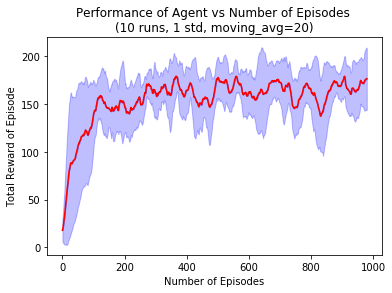

In [8]:
%matplotlib inline
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

means = np.mean([moving_average(rewards) for rewards in run_rewards], axis=0)
stds = np.std([moving_average(rewards) for rewards in run_rewards], axis=0)

plt.plot(range(len(means)), means, color='red')

plt.fill_between(range(len(means)), means, means + stds, color='blue', alpha=.25)
plt.fill_between(range(len(means)), means, means - stds, color='blue', alpha=.25)

plt.title('Performance of Agent vs Number of Episodes \n(10 runs, 1 std, moving_avg=20)')
plt.xlabel('Number of Episodes')
plt.ylabel('Total Reward of Episode')

plt.show()